<a href="https://colab.research.google.com/github/ManuelBagasina/DATCapstone/blob/Ri-on2/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [164]:
!git clone https://github.com/ManuelBagasina/DATCapstone.git

fatal: destination path 'DATCapstone' already exists and is not an empty directory.


In [165]:
!pip install tensorflow

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [167]:
df = pd.read_csv('/content/DATCapstone/data_preprocessed/df_preprocessed.csv', index_col='Date')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,GDP (Billions USD),Unemployment Rate (%),Producer Price Index (PPI),...,reddit_Comment2_Sentiment_negative,reddit_Comment2_Sentiment_neutral,reddit_Comment2_Sentiment_positive,reddit_Comment3_Sentiment_negative,reddit_Comment3_Sentiment_neutral,reddit_Comment3_Sentiment_positive,Target_1day,Target_1week,Target_1month,Target_1year
Date,,,,,,,,,,,,,,,,,,,,,
2021-09-30,140.983639,141.690227,138.647974,138.863876,89056700,0.0,0.0,23921.991,4.7,235.678,...,0.0,1.0,1.0,0.0,0.0,2.0,1.128616,1.756699,10.863815,9.008636
2021-10-01,139.256465,140.257467,136.518448,139.992493,94639600,0.0,0.0,24777.038,4.5,240.465,...,0.0,0.0,1.0,0.0,0.0,1.0,-3.444611,0.245361,7.016815,0.616699
2021-10-04,139.119068,139.560697,135.694095,136.547882,98322000,0.0,0.0,24777.038,4.5,240.465,...,0.0,0.0,0.0,0.0,0.0,0.0,1.933304,3.601608,9.637054,-0.162506
2021-10-05,136.891371,139.590139,136.763788,138.481186,80861100,0.0,0.0,24777.038,4.5,240.465,...,0.0,0.0,0.0,0.0,0.0,0.0,0.873398,0.392517,8.744003,2.098389
2021-10-06,136.871718,139.501783,135.792205,139.354584,83221100,0.0,0.0,24777.038,4.5,240.465,...,0.0,0.0,0.0,0.0,0.0,0.0,1.265991,-1.069672,9.313263,4.827072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,255.209412,257.926411,255.009620,257.916443,23234700,0.0,0.0,29700.580,4.1,253.590,...,0.0,0.0,0.0,0.0,0.0,0.0,0.819061,NaN,NaN,NaN
2024-12-26,257.906429,259.814335,257.347047,258.735504,27237100,0.0,0.0,29700.580,4.1,253.590,...,0.0,0.0,0.0,0.0,0.0,0.0,-3.426208,NaN,NaN,NaN
2024-12-27,257.546826,258.415896,252.782075,255.309296,42355300,0.0,0.0,29700.580,4.1,253.590,...,0.0,0.0,0.0,0.0,0.0,0.0,-3.386276,NaN,NaN,NaN


In [168]:
df_1day = df.drop(['Target_1week', 'Target_1month', 'Target_1year'], axis=1)
df_1day.dropna(inplace = True)

df_1week = df.drop(['Target_1day', 'Target_1month', 'Target_1year'], axis=1)
df_1week.dropna(inplace = True)

df_1month = df.drop(['Target_1week', 'Target_1day', 'Target_1year'], axis=1)
df_1month.dropna(inplace = True)

df_1year = df.drop(['Target_1week', 'Target_1month', 'Target_1day'], axis=1)
df_1year.dropna(inplace = True)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 28s 274ms/step - loss: 0.3959 - val_loss: 0.0162
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - loss: 0.0177 - val_loss: 0.0180
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - loss: 0.0129 - val_loss: 0.0151
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - loss: 0.0136 - val_loss: 0.0153
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - loss: 0.0143 - val_loss: 0.0154
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - loss: 0.0122 - val_loss: 0.0152
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - loss: 0.0124 - val_loss: 0.0154
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - loss: 0.0139 - val_loss: 0.0170
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step


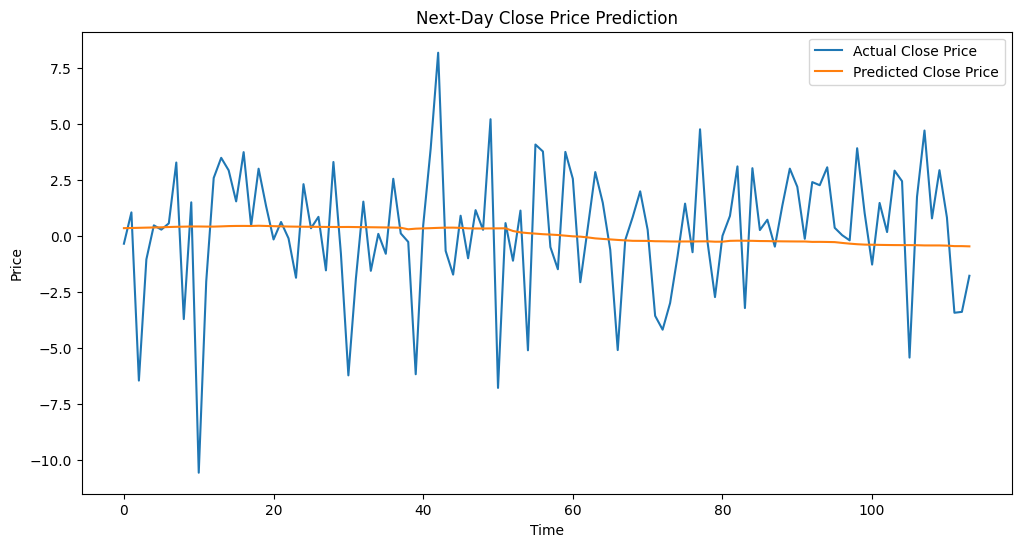

MSE: 8.16865898804364
MAE: 2.119936542170537


In [169]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error

df = df_1day

# Feature Engineering
df['Close_lag1'] = df['Close'].shift(1)
df['Close_lag3'] = df['Close'].shift(3)
df['Close_lag7'] = df['Close'].shift(7)
df['Close_lag14'] = df['Close'].shift(14)
df['Close_lag30'] = df['Close'].shift(30)
df['Close_rolling_mean_3'] = df['Close'].rolling(window=3).mean()
df['Close_rolling_mean_7'] = df['Close'].rolling(window=7).mean()

df.dropna(inplace=True)
df

features = df.columns.tolist()
target_col = 'Target_1day'
target_index = features.index(target_col)

# Normalization
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

# Sequences generation
def create_sequences(data, target_index, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data) - 1):  # 다음날 종가 예측
        X.append(data[i - seq_len:i])
        y.append(data[i + 1, target_index])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(scaled, target_index, seq_length)

# Split
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

# LSTM model
model = Sequential()
model.add(LSTM(256, return_sequences=True, dropout=0.2))
model.add(LSTM(128))
model.add(Dense(64))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# 8. Model Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# Prediction
pred = model.predict(X_test)

# inverse rescale
def inverse_rescale(pred, y_true, scaler, target_index):
    dummy_pred = np.zeros((len(pred), len(features)))
    dummy_pred[:, target_index] = pred[:, 0]
    pred_real = scaler.inverse_transform(dummy_pred)[:, target_index]

    dummy_actual = np.zeros((len(y_true), len(features)))
    dummy_actual[:, target_index] = y_true
    actual_real = scaler.inverse_transform(dummy_actual)[:, target_index]

    return pred_real, actual_real

predicted_price, actual_price = inverse_rescale(pred, y_test, scaler, target_index)

# Visualization
plt.figure(figsize=(12,6))
plt.plot(actual_price, label='Actual Close Price')
plt.plot(predicted_price, label='Predicted Close Price')
plt.title('Next-Day Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

print("MSE:", mean_squared_error(actual_price, predicted_price))
print("MAE:", mean_absolute_error(actual_price, predicted_price))

In [170]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. baseline 예측: 학습 데이터의 target 평균(스케일된 값)을 구한 후, 이를 실제 값으로 변환
baseline_scaled_value = np.mean(y_train)  # 스케일된 학습 target 평균
dummy = np.zeros((1, len(features)))       # scaler가 사용한 전체 feature 개수와 맞춤
dummy[0, target_index] = baseline_scaled_value
baseline_value_actual = scaler.inverse_transform(dummy)[0, target_index]

# 테스트 셋 전체에 대해 같은 값으로 baseline 예측 생성
baseline_pred = np.full(shape=len(actual_price), fill_value=baseline_value_actual)

# 2. baseline 성능 평가 (역스케일된 실제 값과 비교)
baseline_mse = mean_squared_error(actual_price, baseline_pred)
baseline_mae = mean_absolute_error(actual_price, baseline_pred)

print("LSTM 모델 MSE:", mean_squared_error(actual_price, predicted_price))
print("LSTM 모델 MAE:", mean_absolute_error(actual_price, predicted_price))
print("Baseline (평균) MSE:", baseline_mse)
print("Baseline (평균) MAE:", baseline_mae)

LSTM 모델 MSE: 8.16865898804364
LSTM 모델 MAE: 2.119936542170537
Baseline (평균) MSE: 7.985293920891263
Baseline (평균) MAE: 2.0976562785915664


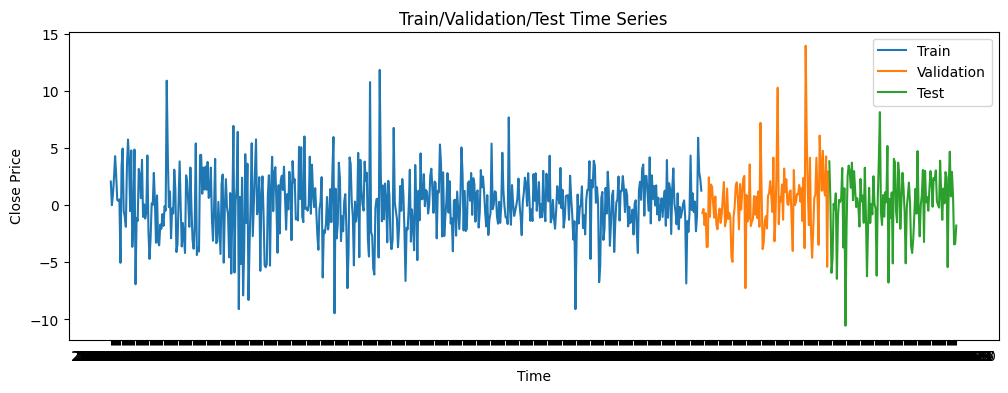

In [171]:
import matplotlib.pyplot as plt

# 예시: train/val/test 구간 인덱스
train_size = int(len(df) * 0.7)
val_size   = int(len(df) * 0.15)
test_size  = len(df) - (train_size + val_size)

# 라인 플롯 (시계열)
plt.figure(figsize=(12, 4))
plt.plot(df.index[:train_size], df['Target_1day'][:train_size], label='Train')
plt.plot(df.index[train_size:train_size+val_size], df['Target_1day'][train_size:train_size+val_size], label='Validation')
plt.plot(df.index[train_size+val_size:], df['Target_1day'][train_size+val_size:], label='Test')
plt.title('Train/Validation/Test Time Series')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()


# Classification

In [172]:
df = df_1day.copy()
df['Target_1day'] = df_1day['Target_1day'].apply(lambda x: True if x > 0 else False)

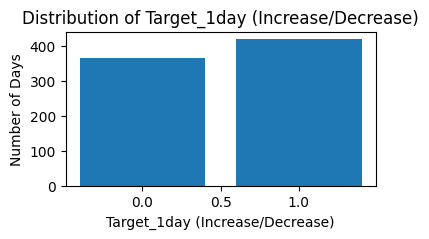

In [173]:
# prompt: df_1day bar plot

import matplotlib.pyplot as plt
# Bar plot for df_1day
df_counts = df['Target_1day'].value_counts()
plt.figure(figsize=(4, 2))
plt.bar(df_counts.index, df_counts.values)
plt.xlabel('Target_1day (Increase/Decrease)')
plt.ylabel('Number of Days')
plt.title('Distribution of Target_1day (Increase/Decrease)')
plt.show()


In [174]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Feature engineering
df['Close_lag1'] = df['Close'].shift(1)
df['Close_lag3'] = df['Close'].shift(3)
df['Close_lag7'] = df['Close'].shift(7)
df['Close_lag14'] = df['Close'].shift(14)
df['Close_lag30'] = df['Close'].shift(30)
df['Close_rolling_mean_3'] = df['Close'].rolling(window=3).mean()
df['Close_rolling_mean_7'] = df['Close'].rolling(window=7).mean()

# Categorical target
df['Target_1day'] = (df['Close'].shift(-1) > df['Close']).astype(int)
df.dropna(inplace=True)

feature_cols = [col for col in df.columns if col != 'Target_1day']
target_col = 'Target_1day'

# scaling
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[feature_cols])
features_data = scaled_features.astype(np.float32)
target_data = df[target_col].values.astype(np.float32)

# sequence
def create_sequences(features, target, seq_len):
    X, y = [], []
    for i in range(seq_len, len(features) - 1):
        X.append(features[i - seq_len:i])
        y.append(target[i + 1])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

seq_length = 30
X, y = create_sequences(features_data, target_data, seq_length)

# split
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

# LSTM
model = Sequential([
    Input(shape=(seq_length, X_train.shape[2])),
    LSTM(256, return_sequences=True, dropout=0.2),
    LSTM(128),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Adam
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# Eval
pred_probs = model.predict(X_test)
pred_labels = (pred_probs > 0.5).astype(int)

accuracy = accuracy_score(y_test, pred_labels)
print("Test Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, pred_labels))

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/step - accuracy: 0.4735 - loss: 0.7096 - val_accuracy: 0.5833 - val_loss: 0.6923
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.5333 - loss: 0.6942 - val_accuracy: 0.5833 - val_loss: 0.6911
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.5245 - loss: 0.6940 - val_accuracy: 0.4167 - val_loss: 0.7013
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.5107 - loss: 0.6931 - val_accuracy: 0.5833 - val_loss: 0.6898
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.4241 - loss: 0.6963 - val_accuracy: 0.5833 - val_loss: 0.6920
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.5193 - loss: 0.6934 - val_accuracy: 0.6296 - val_loss: 0.6930
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.5396 - loss: 0.6925 - val_accuracy: 0.4167 - val_loss: 0.6980
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 0.5045 - loss: 0.6944 - val_accuracy: 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
[[ 0 43]
 [ 0 67]]


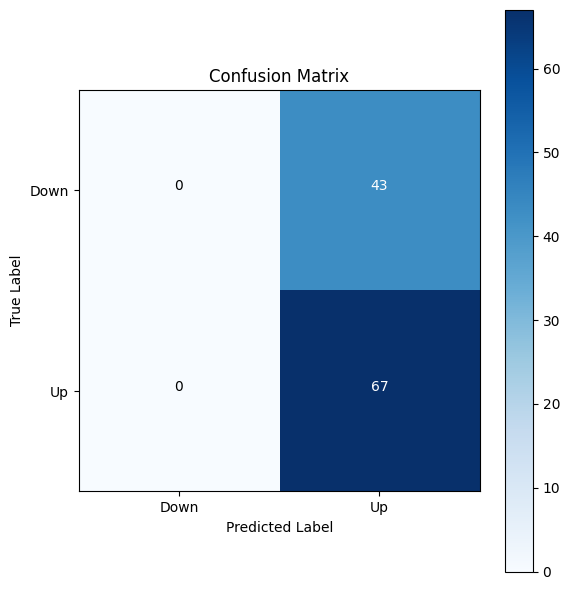

In [175]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# confusion matrix
cm = confusion_matrix(y_test, pred_labels)
print("Confusion Matrix:")
print(cm)

# confusion matrix visualization
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Down', 'Up'])
plt.yticks(tick_marks, ['Down', 'Up'])

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()